In [3]:
# Downloading PDFs
import requests
from bs4 import BeautifulSoup
import wget

# Data handling
import pandas as pd
import numpy as np
import datetime
import re

# Statistics
import statsmodels.tsa.x13 as sx13

# I/O
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# set directory for files to be stored
DIR = "Data"
os.chdir(DIR)

### Downloading PDFs

In [21]:
# url template for table listing page
main_page = "https://www2.census.gov/programs-surveys/qtax/tables/{}/q4t1.pdf"

In [23]:
years = map(str,range(1962,1994))
for year in years:
    try:
        wget.download(main_page.format(year), "{}.pdf".format(year))
    except:
        print("{} table failed to download".format(year))

1962 table failed to download
1977 table failed to download
1979 table failed to download
1981 table failed to download
1983 table failed to download
1992 table failed to download


Notes: 
Went back and manually downloaded the tables that raised errors
Only quarters 1 and 2 available for 1992

### Reading and organizing data

In [5]:
''' Read in all tax data
Columns:
Period - indicates yaer and quarter in format (YYYY-Q[1-4])
Category - indicates type of tax. Types included are:
    - Property 
    - General Sales and Gross Receipts 
    - Alcoholic Beverages Sales 
    - Amusements Sales 
    - Insurance Premiums Sales 
    - Motor Fuels Sales 
    - Pari-Mutuels Sales 
    - Public Utilities Sales 
    - Tobacco Products Sales 
    - Other Selective Sales and Gross Receipts 
    - Alcoholic Beverages License
    - Amusements License
    - Corporations in General License
    - Hunting and Fishing License
    - Motor Vehicles License
    - Motor Vehicles Operators License
    - Public Utilities License
    - Occupation and Business License
    - Other License 
    - Individual Income 
    - Corporation Net Income 
    - Death and Gift 
    - Documentary and Stock Transfer 
    - Severance 
    - Other Not Elsewhere Classified
    - Total 
    See dataset documentation for detail on category definitions.
State - indicates state with postal abbreviation. US denotes the total of all states except the District of Columbia.
Value - indicates revenue in millions of dollars. Negative numbers indicate that refunds exceeded revenues.
'''

# Note: I did some initial data cleanup (e.g. renaming columns, deleting unneccessary columns, INDEX/MATCH-ing numerical keys
# with their corresponding English language values for ease of reference) in Excel. When I have some time I'll automate the
# data cleaning in pandas so new quarters can be added quickly.

file_path = "QTAX-edit.csv"
qtax_full = pd.read_csv(file_path, header = 0, index_col = "Period",
                       dtype = {'Category':'S','State':'S','Value':'i8'},parse_dates = True, infer_datetime_format = True)
qtax_full.dropna(inplace = True)

In [4]:
# Checking that data is structured correctly
qtax_full.head()
qtax_full.tail()

,Category,State,Value
Period,,,
2020-01-01,Total,VT,631
2020-01-01,Total,WA,8254
2020-01-01,Total,WI,4140
2020-01-01,Total,WV,1325
2020-01-01,Total,WY,446


In [7]:
totals = qtax_full[qtax_full.Category == "Total"]
# Pull totals for 15 most populous states
california_total = totals[totals.State == "CA"]["Value"]
texas_total = totals[totals.State == "TX"]["Value"]
florida_total = totals[totals.State == "FL"]["Value"]
newyork_total = totals[totals.State == "NY"]["Value"]
pennsylvania_total = totals[totals.State == "PA"]["Value"]
illinois_total = totals[totals.State == "IL"]["Value"]
ohio_total = totals[totals.State == "OH"]["Value"]
georgia_total = totals[totals.State == "GA"]["Value"]
northcarolina_total = totals[totals.State == "NC"]["Value"]
michigan_total = totals[totals.State == "MI"]["Value"]
newjersey_total = totals[totals.State == "NJ"]["Value"]
virginia_total = totals[totals.State == "VA"]["Value"]
washington_total = totals[totals.State == "WA"]["Value"]
arizona_total = totals[totals.State == "AZ"]["Value"]
massachusetts_total = totals[totals.State == "MA"]["Value"]

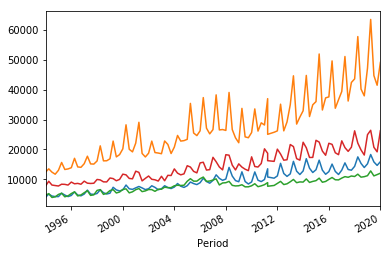

In [8]:
texas_total.plot()
california_total.plot()
florida_total.plot()
newyork_total.plot()

In [29]:
# Having issue with statsmodels wrapper for CB x13 binary. Not sure why the error message is still showing since
# I deleted it from the package. Going to just do seasonal adjustment directly from CB program for the time being. 
%env X13 = "./x13as"
sx13.x13_arima_analysis(texas_totals)

env: X13="/SA/x13as"


X13NotFoundError: x12a and x13as not found on path. Give the path, put them on PATH, or set the X12PATH or X13PATH environmental variable.

In [28]:
class QTAX_Series():
    def __init__(self, state, data, category):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-28-ab5b5107a6f3>, line 1)

In [129]:
# Dict to reference dataframes by state names for easy file reading/writing
top_15_totals = {"california":california_total,
                 "texas":texas_total,
                 "newyork":newyork_total,
                 "florida":florida_total,
                 "pennsylvania":pennsylvania_total,
                "illinois":illinois_total,
                 "ohio":ohio_total,
                 "georgia":georgia_total,
                 "northcarolina":northcarolina_total,
                 #"michigan":michigan_total, -- removing michigan because data appears to retain noticeable seasonality
                 # even after adjustment
                 "newjersey":newjersey_total,
                 "virginia":virginia_total,
                "washington":washington_total,
                 #"arizona":arizona_total, -- removing arizona becuase revenues are low relative to other states, makes
                 #comparison difficult
                 "massachusetts":massachusetts_total}
# State abbreviation dict to make switching between full name / abbr easier
abbr_lookup = {"california":"CA",
                 "texas":"TX",
                 "newyork":"NY",
                 "florida":"FL",
                 "pennsylvania":"PA",
                "illinois":"IL",
                 "ohio":"OH",
                 "georgia":"GA",
                 "northcarolina":"NC",
                 "michigan":"MI",
                 "newjersey":"NJ",
                 "virginia":"VA",
                "washington":"WA",
                 "arizona":"AZ",
                 "massachusetts":"MA"}


In [130]:
# Save total tax series for selected states as space separated text files to fit X13 expected input format.
#os.chdir("SA")
#for state in top_15_totals:
    #top_15_totals[state].to_csv("{}_total.csv".format(state), header = True, date_format = '%Y-%m')

In [131]:
#date_parser = lambda x: pd.datetime.strptime(x, "%Y:%q")
def read_adj(state,cat = "total"):
    return pd.read_csv("{}_{}_adj.csv".format(state,cat), header = 0,
                       parse_dates = [0], infer_datetime_format = True)

for key in top_15_totals:
    top_15_totals[key] = read_adj(key)
    #top_15_totals[key].time = top_15_totals[key].time.str.replace(":","-Q")
    

In [132]:
top_15_total = pd.DataFrame(columns = ["time","original","adjusted","state"])
for key in top_15_totals:
    top_15_totals[key]["state"] = abbr_lookup[key]
    top_15_total = top_15_total.append(top_15_totals[key])

In [133]:
top_15_total = top_15_total.pivot("time", "state", "adjusted")
top_15_total.index = top_15_total.index.to_period(freq = "Q")
top_15_total.head()

state,CA,FL,GA,IL,MA,NC,NJ,NY,OH,PA,TX,VA,WA
time,,,,,,,,,,,,,
1994Q1,12613.979470,4445.354218,7615.540557,3689.268742,2760.811653,2603.902221,3722.371662,7615.540557,3522.164592,4393.560012,4362.159343,2035.446552,2651.111533
1994Q2,12157.203282,4537.776543,8968.645367,3829.658009,2732.888595,2761.257375,3648.518930,8968.645367,3565.962385,4364.161531,4435.308401,2064.063556,2190.203248
1994Q3,12957.370181,4542.449951,8372.165640,3967.247159,2832.813156,2748.823759,3535.214393,8372.165640,3536.463251,4443.375192,4504.767216,2081.564086,2558.546475
1994Q4,12801.546181,4583.086786,8411.323701,3945.200604,2797.343610,2789.291170,3493.986376,8411.323701,3641.822544,4567.621457,4630.306493,2107.155417,2556.616809
1995Q1,13343.911683,4676.449616,7569.656637,4033.559887,3067.893918,2940.285389,3433.030217,7569.656637,3513.880094,4594.366604,4609.042689,2128.700272,2515.746804


## Total revenue heatmaps 

Text(0.5, 1.0, 'High Revenue States, 2005Q1-2012Q4')

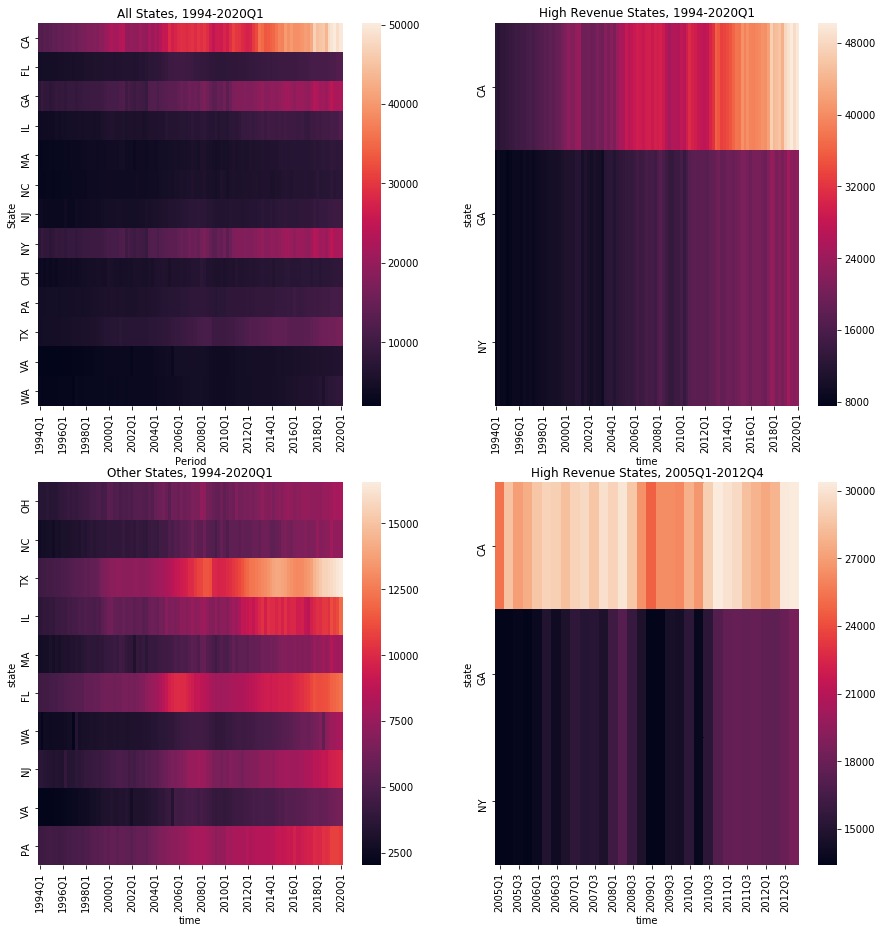

In [134]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]
sns.heatmap(top_15_total.transpose(),ax = ul,xticklabels = 8)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("All States, 1994-2020Q1")
plt.subplots_adjust(bottom=.1)

# Isolate high revenue states
high_rev_states = ["CA","GA","NY"]
sns.heatmap(top_15_total[high_rev_states].transpose(),ax = ur,xticklabels = 8)
ur.set_title("High Revenue States, 1994-2020Q1")

# Other states
other_states = list(set(top_15_total.columns) - set(high_rev_states))
sns.heatmap(top_15_total[other_states].transpose(),ax = ll,xticklabels = 8)
ll.set_title("Other States, 1994-2020Q1")

# Zoom in on 2005-2012
sns.heatmap(top_15_total.loc[pd.Period('2005Q1'):pd.Period('2012Q4'),:][high_rev_states].transpose(),
            ax = lr,xticklabels = 2,robust = True)
lr.set_title("High Revenue States, 2005Q1-2012Q4")